In [ ]:
# pip install qiskit

Optimal parameters: [5.11887867 1.95031411 5.62738929]
Optimal alphas: [1.22848219 0.93873172 0.71108984 0.57180018 0.50776441 0.50782693
 0.57414018 0.72139341 0.95773957 1.20692414]
Predictions: [np.float64(0.27012435362757986), np.float64(0.35626726342272647), np.float64(0.42484032023772383), np.float64(0.47242781033088294), np.float64(0.49691209530079483), np.float64(0.4968921767995168), np.float64(0.4724700302454015), np.float64(0.4248584794994826), np.float64(0.35624380550746587), np.float64(0.27013918582787155)]
Target values: [0.27015115 0.35623731 0.42480378 0.47247847 0.49691675 0.49691675
 0.47247847 0.42480378 0.35623731 0.27015115]


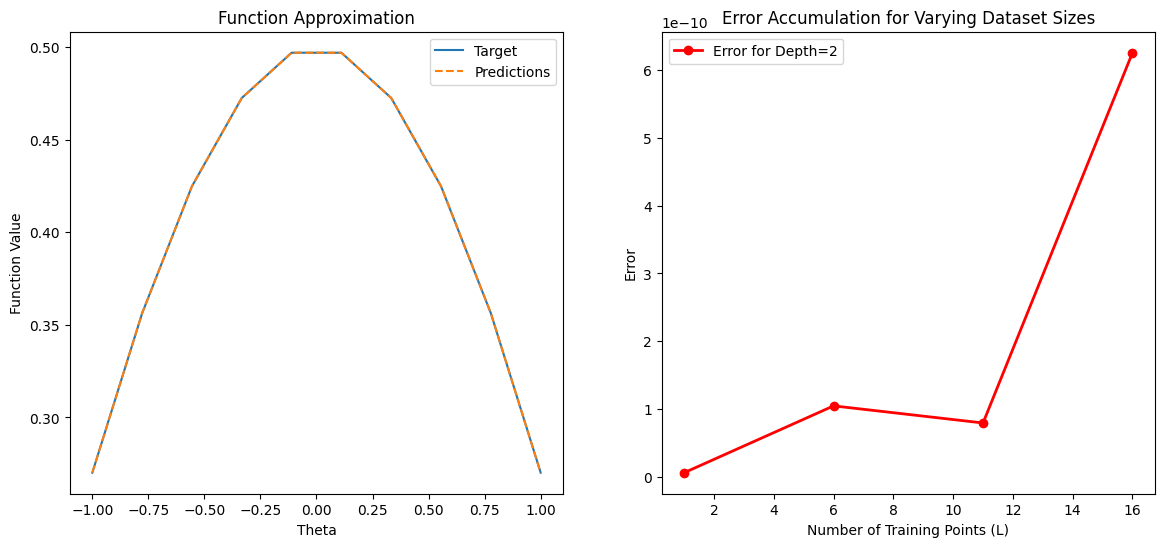

In [1]:
######################### ENTANGLING LAYER ###############################
# this code is the 5-qubit entangling layer on 5 2-qubit gates
# from the paper: https://www.nature.com/articles/s41586-019-1666-5

# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
# 
# we are doing this on signed sum using iter_tools package on Python to find the number of combinations for 5 qubits of [+1, -1]: +1+1-1-1-1
# This becomes a classification task where +1 is positive and -1 is negative: this is a signed sum
# if this is a classification task for horse or dog, you will need more iterations of the entanglement qubits

import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator

CIRCUIT_DEPTH = 2
max_qubits = 5 
# gates used is CIRCUIT_DEPTH*2 + 1
# c (central qubit) and l (maximum number of qubits), run 2 loops and iterate to connect to the central qubit
def entangle(circuit, layer, center):
    # layer is i
    # star entangling pattern, connect 2 to others
    # Insert entangling layer
    # in pairs [2,3], [2,1], [2,0], [2,4]
    # for i = 0, 2, 4 -- do a = 1, for i = 1, 3 do a = -1, you are doing i + a for entangling with qubit 2
    
    step = (layer//2) + 1 # step = 1, 2

    if layer % 2 == 0:
        # even layer, connect 2 to 3, 0
        target = (center - step) % max_qubits
    else:
        # odd layer, connect 2 to 1, 4
        target = (center + step) % max_qubits
    circuit.cx(center, target) 



    '''pairs = [(2, 1), (2, 3), (2, 0), (2, 4)]
    for i, (q1, q2) in enumerate(pairs):
        # if i % 4 == layer % 4:
        circuit.cx(q1, q2)'''

# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    center = 2  # Central qubit for entangling layer
    circuit = QuantumCircuit(5)
    # 20 vs 2 in circuit depth?
    for i in range(CIRCUIT_DEPTH):
        for q in range(5):
            circuit.rz(params[i], q)
            circuit.rx(theta, q)
        entangle(circuit, i, center)
    # final rz layer
    for q in range(5):       
        circuit.rz(params[CIRCUIT_DEPTH], q)
    return circuit

# Function to compute the expectation value <0|U|0> --> |00000>U<00000|
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)
    
    # Projector onto the |00000⟩ state
    projector = np.zeros((2**5, 2**5))
    projector[0,0] = 1 # |00000><00000|
    
    # Compute the expectation value
    expectation = state.expectation_value(Operator(projector))
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

# Training data (x, y) for y = mx
# x_train = np.linspace(-1, 1, 10)
# m = 2.0
# y_train = m * x_train

# Training data (x, y) for y = mcosx
m = 0.5
x_train = np.linspace(-1, 1, 10)
y_train = m * np.cos(x_train)
# m = 0.5
# y_train = m * np.sin(x_train)

# Initialize random parameters, alphas, and phases
# 20 layers of rz + rx per qubit
param_count = CIRCUIT_DEPTH + 1  # RZ per layer + final RZ
init_params = np.random.uniform(0, 2 * np.pi, param_count)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:param_count]
    alphas = params_and_alphas_phases[param_count:param_count+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:param_count]
optimal_alphas = result.x[param_count:param_count+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]

# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")


# Store errors for different dataset sizes
errors = []
L_values = np.arange(1, 20, 5)  # Example: Varying the number of training points from 5 to 20

for L in L_values:
    # Generate training data for this value of L
    x_train = np.linspace(-1, 1, L)
    y_train = m * np.sin(x_train)  # Modify if using cos function
    # y_train = m * np.cos(x_train)

    # Initialize random parameters and alphas
    init_params = np.random.uniform(0, 2 * np.pi, param_count)
    init_alphas = np.random.uniform(0, 1, len(x_train))

    # Define the train function again
    def train(params_and_alphas_phases):
        params = params_and_alphas_phases[:param_count]
        alphas = params_and_alphas_phases[param_count:param_count+len(x_train)]
        return cost(params, alphas, x_train, y_train)

    # Optimize
    init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
    result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

    # Extract the optimized parameters
    optimal_params = result.x[:param_count]
    optimal_alphas = result.x[param_count:param_count+len(x_train)]

    # Compute the final error
    error = cost(optimal_params, optimal_alphas, x_train, y_train)
    errors.append(error)

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Error for Depth={CIRCUIT_DEPTH}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()
plt.show()

Optimal parameters: [0.53215052 4.54725118 2.07779459 3.30052938 5.99279472 5.448605
 2.22500152 0.96538963 4.95973456 4.22871708 4.79919566 4.06282658
 5.74535193 5.45320831 0.20633366 5.89169161 6.18390932 4.3118478
 5.53624471 2.36858173 2.33196191]
Optimal alphas: [-0.5906547  -0.42323422 -0.33419874 -0.24637687 -0.06004931  0.06006045
  0.24636402  0.33428501  0.42325391  0.59066745]
Predictions: [-0.4207510626600986, -0.3508662571950986, -0.2636993740273178, -0.16359229343881307, -0.05543635876605857, 0.055446638967346515, 0.1635837616057884, 0.26376744554677056, 0.35088258391936195, 0.4207601470027173]
Target values: [-0.42073549 -0.35084894 -0.26370769 -0.16359735 -0.05544131  0.05544131
  0.16359735  0.26370769  0.35084894  0.42073549]


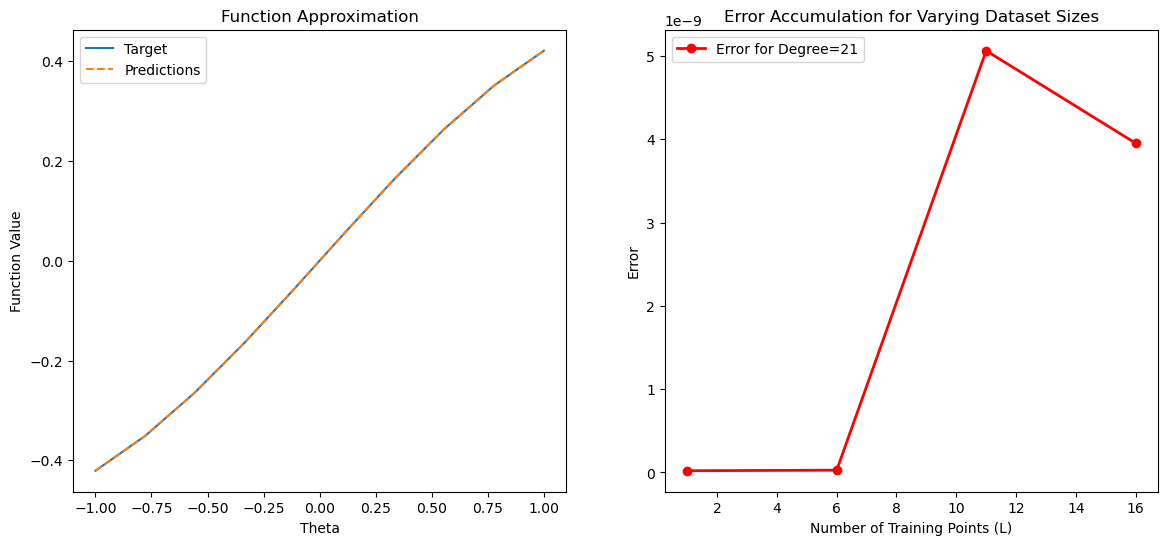

In [1]:
# for the optimizer: Yulong derived the Jacobian differential forms to make his optimizer better. But for us we don't have this
# Yulong's paper calculated a differential and we need to implement this
#
import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator

# Function to create a single-qubit variational circuit
def create_circuit(params, theta):
    circuit = QuantumCircuit(1)
    for i in range(20):
        circuit.rz(params[i], 0)
        circuit.rx(theta, 0)
    circuit.rz(params[20], 0)
    return circuit

# Function to compute the expectation value <0|U|0>
def expectation_value(params, x):
    circuit = create_circuit(params, x)
    state = Statevector.from_instruction(circuit)

    # Projector onto the |0⟩ state
    projector = Operator(np.array([[1, 0], [0, 0]]))

    # Compute the expectation value
    expectation = state.expectation_value(projector)
    return np.real(expectation)

# Cost function incorporating alphas and phase parameters
def cost(params, alphas, x_values, y_values):
    error = 0
    for x, y_true, alpha in zip(x_values, y_values, alphas):
        exp_val = expectation_value(params, x)
        y_pred = alpha * exp_val  # Each alpha corresponds to a specific theta (x)
        error += (y_true - y_pred) ** 2
    return error / len(x_values)

# Training data (x, y) for y = mx
x_train = np.linspace(-1, 1, 10)
#m = 2.0
#y_train = m * x_train

# Training data (x, y) for y = mcosx
# x_train = np.linspace(-1, 1, 10)
m = 0.5
y_train = m * np.sin(x_train)

# Initialize random parameters, alphas, and phases
init_params = np.random.uniform(0, 2 * np.pi, 21)
init_alphas = np.random.uniform(0, 1, len(x_train))

# Training function
def train(params_and_alphas_phases):
    params = params_and_alphas_phases[:21]
    alphas = params_and_alphas_phases[21:21+len(x_train)]
    return cost(params, alphas, x_train, y_train)

# Optimize the parameters, alphas, and phases
init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

# Extract the optimal parameters, alphas, and phases
optimal_params = result.x[:21]
optimal_alphas = result.x[21:21+len(x_train)]

# Test the trained circuit
predictions = [alpha * expectation_value(optimal_params, x) for x, alpha in zip(x_train, optimal_alphas)]

# Print results
print("Optimal parameters:", optimal_params)
print("Optimal alphas:", optimal_alphas)
print("Predictions:", predictions)
print("Target values:", y_train)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x_train, y_train, label="Target")
ax1.plot(x_train, predictions, label="Predictions", linestyle='dashed')
ax1.legend()
ax1.set_title("Function Approximation")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Function Value")


# Store errors for different dataset sizes
errors = []
L_values = np.arange(1, 20, 5)  # Example: Varying the number of training points from 5 to 20

for L in L_values:
    # Generate training data for this value of L
    x_train = np.linspace(-1, 1, L)
    y_train = m * np.sin(x_train)  # Modify if using cos function
    # y_train = m * np.cos(x_train)

    # Initialize random parameters and alphas
    init_params = np.random.uniform(0, 2 * np.pi, 21)
    init_alphas = np.random.uniform(0, 1, len(x_train))

    # Define the train function again
    def train(params_and_alphas_phases):
        params = params_and_alphas_phases[:21]
        alphas = params_and_alphas_phases[21:21+len(x_train)]
        return cost(params, alphas, x_train, y_train)

    # Optimize
    init_params_and_alphas_phases = np.concatenate((init_params, init_alphas))
    result = minimize(train, init_params_and_alphas_phases, method='L-BFGS-B')

    # Extract the optimized parameters
    optimal_params = result.x[:21]
    optimal_alphas = result.x[21:21+len(x_train)]

    # Compute the final error
    error = cost(optimal_params, optimal_alphas, x_train, y_train)
    errors.append(error)

# Plot error accumulation
ax2.plot(L_values, errors, marker='o', linestyle='-', color='red', linewidth=2, label=f"Error for Degree={len(optimal_params)}")
ax2.set_title("Error Accumulation for Varying Dataset Sizes")
ax2.set_xlabel("Number of Training Points (L)")
ax2.set_ylabel("Error")
ax2.legend()
plt.show()